EM algorithm for detecting outliers in data. Discover unusual instances of the one digit in MNIST data.


In [1]:
# import packages
import struct
import numpy as np
from array import array
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy.linalg as LA
from pandas import DataFrame, ExcelWriter
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm # Needed for showing good contour colors
import pickle
from scipy.stats import norm, multivariate_normal
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KernelDensity

In [2]:
def load_mnist(dataset = "training", selecteddigits = range(10), path = r'/Users/elaineyang//Downloads'):

    #Check training/testing specification. Must be "training" (default) or "testing"
    if dataset == "training":
        fname_digits = path + '/' + 'train-images-idx3-ubyte'
        fname_labels = path + '/' + 'train-labels-idx1-ubyte'
    elif dataset == "testing":
        fname_digits = path + '/' + 't10k-images-idx3-ubyte'
        fname_labels = path + '/' + 't10k-labels-idx1-ubyte'
    else:
        raise ValueError("dataset must be 'testing' or 'training'")
        
        
    #Import digits data
    digitsfileobject = open(fname_digits, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", digitsfileobject.read(16))
    digitsdata = array("B", digitsfileobject.read())
    digitsfileobject.close()
    print('magic_nr, size, rows, cols', magic_nr, size, rows, cols)

    #Import label data
    labelsfileobject = open(fname_labels, 'rb')
    magic_nr, size = struct.unpack(">II", labelsfileobject.read(8))
    labelsdata = array("B",labelsfileobject.read())
    labelsfileobject.close()
    
    #Find indices of selected digits
    indices = [k for k in range(size) if labelsdata[k] in selecteddigits]
    N = len(indices)
    print('N', N)
    
    #Create empty arrays for X and T
    X = np.zeros((N, rows * cols), dtype = np.uint8)
    T = np.zeros((N, 1), dtype = np.uint8)
    
    #Fill X from digitsdata
    #Fill T from labelsdata
    for i in range(N):
        X[i] = digitsdata[indices[i] * rows * cols:(indices[i] + 1) * rows * cols]
        T[i] = labelsdata[indices[i]]
    
    return X,T

In [3]:
def vectortoimg(v, width, show = True):
    
    plt.imshow(v.reshape(width, width), interpolation = 'None', cmap = 'gray')
    plt.axis('off')
    if show:
        plt.show()

In [4]:
def pdf(x, mu, sigma):
    
    d = np.alen(mu)
    dfact1 = (2 * np.pi) **d
    dfact2 = np.linalg.det(sigma)
    
    fact = 1 / np.sqrt(dfact1 * dfact2)
    
    xc = x - mu
    isigma = np.linalg.inv(sigma)
    
    return fact * np.exp(-0.5 * np.einsum('ij,jk,ik->i', xc, isigma, xc))

In [5]:
def detect_outlier(data_1):
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    outliers = []
    '''
    z_score = [(y - mean_1) / std_1 for y in data_1]
    if np.where(np.abs(z_score) >= threshold):
        outliers.append(y)
    
    '''
    for y in data_1:
        z_score= (y - mean_1)/std_1
        #print(z_score.shape)
        #print(np.abs(z_score))
        if np.where(np.abs(z_score) >= threshold):
            outliers.append(y)
            #print(y)
            
    return outliers

# EM Algorithm

In [6]:
class EM:
    """
    Full covariance Gaussian Mixture Model,
    trained using Expectation Maximization
    """
    
    def __init__(self, n_components, n_iter, tol, seed):
        self.n_components = n_components
        self.n_iter = n_iter
        self.tol = tol
        self.seed = seed

    def fit(self, X):
        
        # data's dimensionality and responsibility vector
        self.n_row, self.n_col = X.shape     
        self.resp = np.zeros((self.n_row, self.n_components))
        
        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(self.n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.n_components, self.n_col, self.n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))
        
        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      
        
        for i in range(self.n_iter):
            self._do_estep(X)
            self._do_mstep(X)
            log_likelihood_new = self._compute_log_likelihood(X)
           
            if (log_likelihood - log_likelihood_new) <= self.tol:
                self.converged = True
                break
                
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)
            
        return self
      
    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood
        
        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return self
 
    def _do_mstep(self, X):
        """M-step, update parameters"""
        
        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / self.n_row
        
        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self
    
    
    def _compute_log_likelihood(self, X):
        """manually compute the log likelihood of the current parameter"""
        log_likelihood = 0
        for k in range(self.n_components):
            
            weight = self.weights[k]
            mean = self.means[k]
            cov = self.covs[k]
            cov_inverse = np.linalg.inv(cov)
            term_other = np.log(2 * np.pi) + np.log(np.linalg.det(cov))
            
            for x in X:
                # compute (x-mu)^T * Sigma^{-1} * (x-mu)
                diff = x - mean
                term_exponent = np.dot(diff.T, np.dot(cov_inverse, diff))
            
                # compute loglikelihood contribution for this data point and this cluster             
                log_likelihood += -1 / 2 * (term_other + term_exponent) + np.log(weight)
            
        return log_likelihood

In [7]:
def plot_contours(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1] / (sigmax * sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
    
    plt.title(title)
    plt.tight_layout()

In [8]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    
    m = X.shape[0]
    
    #compute mean
    sum_ = np.sum(X, axis = 0)
    mu = 1/m * sum_
    
    # compute variance
    var = 1/m * np.sum((X - mu)**2, axis = 0)
    
    return mu,var

In [9]:
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma2 = np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p

In [10]:
digit = 7

In [11]:
X, T = load_mnist(dataset = "training", selecteddigits = [digit])

magic_nr, size, rows, cols 2051 60000 28 28
N 6265


Checking shape of matrix: (6265, 784)
Checking min/max values: (0, 255)
Checking unique labels in T: [7]
Checking one training vector by plotting image:


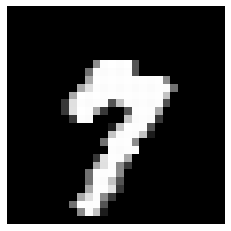

In [12]:
print("Checking shape of matrix:", X.shape)
print("Checking min/max values:", (np.amin(X),np.amax(X)))
print("Checking unique labels in T:", list(np.unique(T)))

print("Checking one training vector by plotting image:")
vectortoimg(X[-20], 28)

Checking multiple training vectors by plotting images.
Be patient:


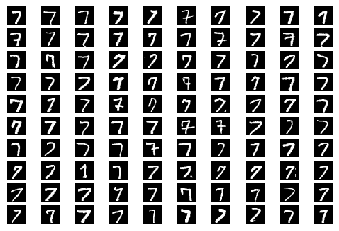

In [25]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure()

nrows = 10
ncols = 10
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row * ncols + col + 1)
        vectortoimg(X[np.random.randint(len(T))], 28, show = False)
plt.show()

# XZCVPR

In [14]:
X = np.array(X, np.float64)
mu = np.mean(X, axis = 0)
Z = X - mu
C = np.cov(Z, rowvar = False)
[λorig, Vorig] = LA.eigh(C)
λF = np.flipud(λorig)
VTF = np.flipud(Vorig.T)
λ = λF[:50]
V = VTF[:50] # reduce the problem dimension to from 784 to 50

print('X\n ', X)
print('mu\n ', mu)
print('mu.shape\n ', mu.shape )
print('Z\n ', Z)
print('C\n ', C)
print('V\n ', V)
print('V.shape\n ', V.shape)

X
  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
mu
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e

In [15]:
P = np.dot(Z, V.T)
R = np.dot(P, V)
Xrec = R + mu

print('P', P)
print('P.shape', P.shape)

P [[-602.63295225 -896.05407054  139.38578923 ...   18.01582833
    33.09746981   86.18323545]
 [-344.5047332   -28.27723896  928.23374036 ...  -20.54985981
    -8.43702955  -23.25358997]
 [ 184.22375484  813.40192494  141.44988423 ...  154.67797982
   164.79358029  -31.74177104]
 ...
 [-728.51959474 -429.82771487  536.04894279 ...  -89.9660374
    68.34448093   30.16041504]
 [-728.65260395  182.67074173   52.03375064 ...   -6.88864018
   -11.5247131    99.97617768]
 [-240.47412065 -837.68155584  887.60971671 ...  -95.75669842
   108.67183843 -102.94472054]]
P.shape (6265, 50)


In [16]:
mu_P, sigma_P = estimateGaussian(P)
PP = multivariateGaussian(P, mu_P, sigma_P)
print(PP)

[1.69033777e-134 6.28913799e-140 4.73766386e-145 ... 1.45385378e-139
 6.55577456e-136 6.60728087e-146]


In [17]:
pdf = multivariate_normal.pdf(P, mean=np.mean(P, axis = 0), cov=np.cov((P-np.mean(P, axis = 0)), rowvar = False))
print(pdf)

[1.68738655e-134 6.29069795e-140 4.74777004e-145 ... 1.45401989e-139
 6.54772414e-136 6.62345757e-146]


In [18]:
gmm = GaussianMixture(n_components = 11)
gmm.fit(P)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=11, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [19]:
estimator = GaussianMixture(n_components = 11, covariance_type = 'full', max_iter = 100, init_params = 'kmeans')
estimator.fit(P)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=11, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [20]:
print(gmm.fit(P))
print(estimator.fit(P))

print("gmm.means_.shape = \n ", gmm.means_.shape)
print("gmm.means_ = ", gmm.means_)
print("gmm.weights_ = ", gmm.weights_)

print("estimator.means_.shape = ", estimator.means_.shape)
print("estimator.means_ = ", estimator.means_)
print("estimator.weights_ = ", estimator.weights_)

print("mu_P = ", mu_P)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=11, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=11, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)
gmm.means_.shape = 
  (11, 50)
gmm.means_ =  [[ 6.58246987e+02  3.26478862e+02  2.06729830e+02 -4.61941358e+01
   5.16888318e+01 -3.25695517e+02 -1.18212005e+01  1.54064847e+02
  -1.10048562e+02 -7.59228809e+01  5.39529428e+01  6.39396955e+01
  -1.17798630e+00  5.41922376e+00 -2.92652154e+00  2.59413283e+01
   8.53253776e+01 -4.12266665e+00  2.93044208e+

# Find 10 outliers

In [21]:
threshold=0.115
outliers=[]
outliers_index=[]
for index, y in enumerate(P):
    z_score= (y - mu_P)/sigma_P
    if np.linalg.norm(z_score) > threshold:
        outliers.append(y)
        outliers_index.append(index)

In [22]:
print("outliers_index: \n", outliers_index)

outliers_index: 
 [238, 253, 295, 530, 890, 1228, 1579, 1641, 2114, 2790, 2816, 4164, 4231, 4329, 5263]


In [23]:
Xrec1 = X[outliers_index[0]]
Xrec2 = X[outliers_index[1]]
Xrec3 = X[outliers_index[2]]
Xrec4 = X[outliers_index[3]]
Xrec5 = X[outliers_index[4]]
Xrec6 = X[outliers_index[5]]
Xrec7 = X[outliers_index[6]]
Xrec8 = X[outliers_index[7]]
Xrec9 = X[outliers_index[8]]
Xrec10 = X[outliers_index[9]]

Plot 10 Outliers

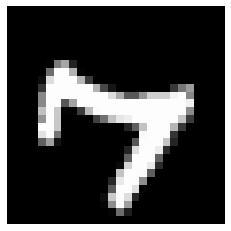

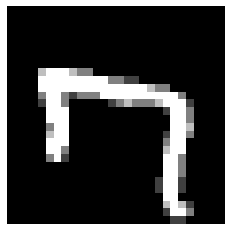

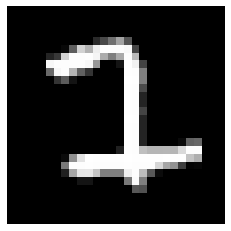

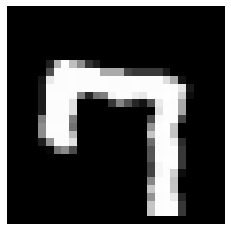

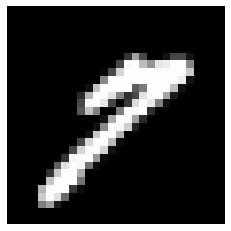

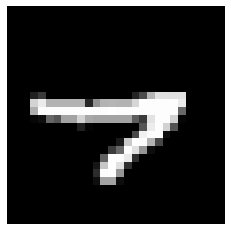

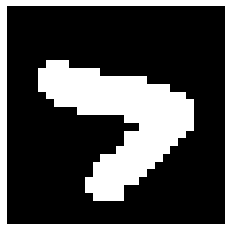

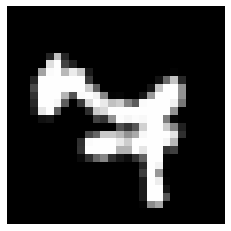

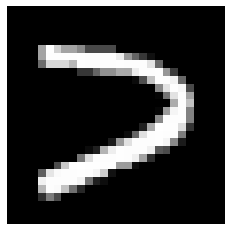

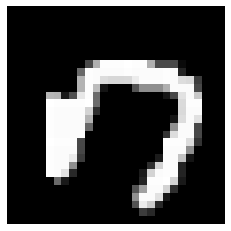

In [24]:
vectortoimg(Xrec1, 28)
vectortoimg(Xrec2, 28)
vectortoimg(Xrec3, 28)
vectortoimg(Xrec4, 28)
vectortoimg(Xrec5, 28)
vectortoimg(Xrec6, 28)
vectortoimg(Xrec7, 28)
vectortoimg(Xrec8, 28)
vectortoimg(Xrec9, 28)
vectortoimg(Xrec10, 28)